<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:06:44] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


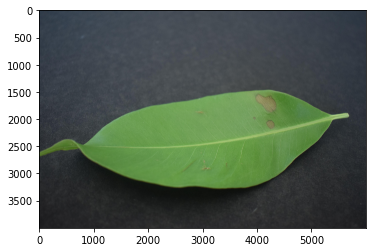

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

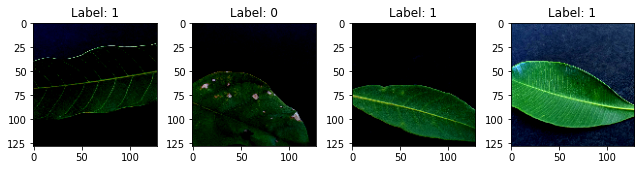

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:06:52] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:06:54] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2520312316464526 samples/sec                   batch loss = 0.4054773449897766 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2657469240376784 samples/sec                   batch loss = 0.33152905106544495 | accuracy = 0.7


Epoch[1] Batch[15] Speed: 1.2625719185254627 samples/sec                   batch loss = 0.636638343334198 | accuracy = 0.6666666666666666


Epoch[1] Batch[20] Speed: 1.2735463752560041 samples/sec                   batch loss = 1.255938172340393 | accuracy = 0.6375


Epoch[1] Batch[25] Speed: 1.2638745871668624 samples/sec                   batch loss = 0.4505448043346405 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.2657326956643498 samples/sec                   batch loss = 0.9541726112365723 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2674364510846237 samples/sec                   batch loss = 1.2407151460647583 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.264863843612158 samples/sec                   batch loss = 0.3790442645549774 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.265526754303222 samples/sec                   batch loss = 0.6487936973571777 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.266126242413302 samples/sec                   batch loss = 0.48852112889289856 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.261910295632359 samples/sec                   batch loss = 2.409414768218994 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2695945590586188 samples/sec                   batch loss = 0.42236751317977905 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2685240345425453 samples/sec                   batch loss = 0.32629796862602234 | accuracy = 0.6307692307692307


Epoch[1] Batch[70] Speed: 1.264779264671914 samples/sec                   batch loss = 0.5332596898078918 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.264074752818439 samples/sec                   batch loss = 0.9537915587425232 | accuracy = 0.6366666666666667


Epoch[1] Batch[80] Speed: 1.2605575880014075 samples/sec                   batch loss = 0.8536009192466736 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2631213444431169 samples/sec                   batch loss = 0.30296680331230164 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.268267231509651 samples/sec                   batch loss = 0.8898273706436157 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.2665810362110532 samples/sec                   batch loss = 1.045398235321045 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2598850175414409 samples/sec                   batch loss = 0.6907106637954712 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.270591253927994 samples/sec                   batch loss = 0.624525785446167 | accuracy = 0.638095238095238


Epoch[1] Batch[110] Speed: 1.2610108536333022 samples/sec                   batch loss = 0.5028021335601807 | accuracy = 0.6431818181818182


Epoch[1] Batch[115] Speed: 1.2622543631366583 samples/sec                   batch loss = 0.3616909086704254 | accuracy = 0.6478260869565218


Epoch[1] Batch[120] Speed: 1.2654167936001826 samples/sec                   batch loss = 0.36124151945114136 | accuracy = 0.6479166666666667


Epoch[1] Batch[125] Speed: 1.256522644378038 samples/sec                   batch loss = 0.3557780981063843 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2668479662319176 samples/sec                   batch loss = 0.5057585835456848 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2700984800045907 samples/sec                   batch loss = 0.7260894775390625 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2675817183780511 samples/sec                   batch loss = 0.3841744661331177 | accuracy = 0.6571428571428571


Epoch[1] Batch[145] Speed: 1.2578352975963862 samples/sec                   batch loss = 0.5117411017417908 | accuracy = 0.656896551724138


Epoch[1] Batch[150] Speed: 1.2644984331334874 samples/sec                   batch loss = 1.414798378944397 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.272913185585652 samples/sec                   batch loss = 0.5850237011909485 | accuracy = 0.6516129032258065


Epoch[1] Batch[160] Speed: 1.2688362122720451 samples/sec                   batch loss = 0.6369943618774414 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.2716205491295722 samples/sec                   batch loss = 0.28122401237487793 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.2651566675431731 samples/sec                   batch loss = 0.6410882472991943 | accuracy = 0.6485294117647059


Epoch[1] Batch[175] Speed: 1.2681868940388576 samples/sec                   batch loss = 0.394142210483551 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2701214605671238 samples/sec                   batch loss = 0.5175493359565735 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.2767153839521599 samples/sec                   batch loss = 0.8048367500305176 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.263152917686059 samples/sec                   batch loss = 0.39910098910331726 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.258037611068549 samples/sec                   batch loss = 0.47872835397720337 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.2678590348132666 samples/sec                   batch loss = 0.5910493731498718 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.2680546182344616 samples/sec                   batch loss = 0.8254320621490479 | accuracy = 0.6365853658536585


Epoch[1] Batch[210] Speed: 1.269357874491123 samples/sec                   batch loss = 0.3599500060081482 | accuracy = 0.638095238095238


Epoch[1] Batch[215] Speed: 1.263410317509744 samples/sec                   batch loss = 0.4573536515235901 | accuracy = 0.6406976744186047


Epoch[1] Batch[220] Speed: 1.2635755995147306 samples/sec                   batch loss = 0.5230980515480042 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2610309473620125 samples/sec                   batch loss = 0.311847448348999 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2646193870281737 samples/sec                   batch loss = 0.4914364218711853 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2640785624845872 samples/sec                   batch loss = 0.6443995237350464 | accuracy = 0.6478723404255319


Epoch[1] Batch[240] Speed: 1.259083604266345 samples/sec                   batch loss = 0.5387315154075623 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2664029222982702 samples/sec                   batch loss = 0.31988200545310974 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2640977064045988 samples/sec                   batch loss = 0.44624948501586914 | accuracy = 0.647


Epoch[1] Batch[255] Speed: 1.2725937861176422 samples/sec                   batch loss = 0.7860029935836792 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2652924426730427 samples/sec                   batch loss = 0.635246217250824 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2622186564605098 samples/sec                   batch loss = 0.37760406732559204 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2626037493663356 samples/sec                   batch loss = 0.3532979488372803 | accuracy = 0.6509259259259259


Epoch[1] Batch[275] Speed: 1.2683635923779715 samples/sec                   batch loss = 0.36534303426742554 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2687605041762609 samples/sec                   batch loss = 1.1416516304016113 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.2626439440343682 samples/sec                   batch loss = 0.4047831892967224 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2647440824014224 samples/sec                   batch loss = 0.4010814130306244 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2708145371676085 samples/sec                   batch loss = 0.5513474345207214 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.271070735838733 samples/sec                   batch loss = 0.6540384888648987 | accuracy = 0.6608333333333334


Epoch[1] Batch[305] Speed: 1.270038292179687 samples/sec                   batch loss = 0.7990095019340515 | accuracy = 0.6598360655737705


Epoch[1] Batch[310] Speed: 1.2662734076799924 samples/sec                   batch loss = 0.6263327598571777 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2657832126125521 samples/sec                   batch loss = 0.5369009375572205 | accuracy = 0.6571428571428571


Epoch[1] Batch[320] Speed: 1.265803554223785 samples/sec                   batch loss = 0.7410386800765991 | accuracy = 0.659375


Epoch[1] Batch[325] Speed: 1.276586762763896 samples/sec                   batch loss = 0.40903475880622864 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.267649048659658 samples/sec                   batch loss = 0.31000715494155884 | accuracy = 0.6598484848484848


Epoch[1] Batch[335] Speed: 1.26245211592889 samples/sec                   batch loss = 0.7191717624664307 | accuracy = 0.6604477611940298


Epoch[1] Batch[340] Speed: 1.2619554770208516 samples/sec                   batch loss = 0.2871267795562744 | accuracy = 0.6625


Epoch[1] Batch[345] Speed: 1.2635460986925475 samples/sec                   batch loss = 0.5471656918525696 | accuracy = 0.6644927536231884


Epoch[1] Batch[350] Speed: 1.266197527290028 samples/sec                   batch loss = 0.658536434173584 | accuracy = 0.665


Epoch[1] Batch[355] Speed: 1.266245405419358 samples/sec                   batch loss = 0.637662947177887 | accuracy = 0.6647887323943662


Epoch[1] Batch[360] Speed: 1.264074752818439 samples/sec                   batch loss = 2.221851348876953 | accuracy = 0.6638888888888889


Epoch[1] Batch[365] Speed: 1.269997529225388 samples/sec                   batch loss = 0.39711490273475647 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.264131138222525 samples/sec                   batch loss = 0.2582590878009796 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.2689880395049036 samples/sec                   batch loss = 0.2978482246398926 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.25715187468477 samples/sec                   batch loss = 0.7963906526565552 | accuracy = 0.6690789473684211


Epoch[1] Batch[385] Speed: 1.260986306031882 samples/sec                   batch loss = 0.4412393271923065 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2653646834830214 samples/sec                   batch loss = 0.6311836838722229 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2721915786505995 samples/sec                   batch loss = 0.9495896697044373 | accuracy = 0.6734177215189874


Epoch[1] Batch[400] Speed: 1.266145926174915 samples/sec                   batch loss = 0.8406944274902344 | accuracy = 0.674375


Epoch[1] Batch[405] Speed: 1.2622417326187068 samples/sec                   batch loss = 0.3596029281616211 | accuracy = 0.6765432098765433


Epoch[1] Batch[410] Speed: 1.2646479847113512 samples/sec                   batch loss = 1.0207959413528442 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.2630628620333326 samples/sec                   batch loss = 0.5284703969955444 | accuracy = 0.6771084337349398


Epoch[1] Batch[420] Speed: 1.268417196452288 samples/sec                   batch loss = 0.3271258771419525 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2755941240551587 samples/sec                   batch loss = 0.48223480582237244 | accuracy = 0.6776470588235294


Epoch[1] Batch[430] Speed: 1.2623897059791747 samples/sec                   batch loss = 0.3070639371871948 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2709275560923932 samples/sec                   batch loss = 0.45146024227142334 | accuracy = 0.6821839080459771


Epoch[1] Batch[440] Speed: 1.267342049984167 samples/sec                   batch loss = 0.44993025064468384 | accuracy = 0.6829545454545455


Epoch[1] Batch[445] Speed: 1.2678175493705315 samples/sec                   batch loss = 0.7018219232559204 | accuracy = 0.6820224719101123


Epoch[1] Batch[450] Speed: 1.2657962006081207 samples/sec                   batch loss = 0.41925346851348877 | accuracy = 0.6827777777777778


Epoch[1] Batch[455] Speed: 1.2626736878357403 samples/sec                   batch loss = 0.8694635629653931 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2648897821487801 samples/sec                   batch loss = 0.17525556683540344 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.2692793193355045 samples/sec                   batch loss = 1.0075268745422363 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.266330084987264 samples/sec                   batch loss = 0.5541043281555176 | accuracy = 0.6851063829787234


Epoch[1] Batch[475] Speed: 1.2576127807854054 samples/sec                   batch loss = 0.5814516544342041 | accuracy = 0.6863157894736842


Epoch[1] Batch[480] Speed: 1.2632121693268297 samples/sec                   batch loss = 1.1061228513717651 | accuracy = 0.6875


Epoch[1] Batch[485] Speed: 1.2660995843138492 samples/sec                   batch loss = 0.4114941358566284 | accuracy = 0.6865979381443299


Epoch[1] Batch[490] Speed: 1.2674130888537527 samples/sec                   batch loss = 0.5582208633422852 | accuracy = 0.6862244897959183


Epoch[1] Batch[495] Speed: 1.2664547355640776 samples/sec                   batch loss = 0.6065951585769653 | accuracy = 0.6853535353535354


Epoch[1] Batch[500] Speed: 1.258421383692143 samples/sec                   batch loss = 0.768586277961731 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.2590300302975292 samples/sec                   batch loss = 0.9228841662406921 | accuracy = 0.6846534653465347


Epoch[1] Batch[510] Speed: 1.2675498275831067 samples/sec                   batch loss = 0.47991234064102173 | accuracy = 0.6838235294117647


Epoch[1] Batch[515] Speed: 1.2694265461918677 samples/sec                   batch loss = 0.6174936890602112 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2669849657634515 samples/sec                   batch loss = 0.7690491080284119 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.2619468391523274 samples/sec                   batch loss = 0.4825133979320526 | accuracy = 0.6847619047619048


Epoch[1] Batch[530] Speed: 1.2673140004403853 samples/sec                   batch loss = 0.43894627690315247 | accuracy = 0.684433962264151


Epoch[1] Batch[535] Speed: 1.2636564007549151 samples/sec                   batch loss = 0.6844943761825562 | accuracy = 0.6841121495327103


Epoch[1] Batch[540] Speed: 1.2704877233330316 samples/sec                   batch loss = 0.9045633673667908 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.2649455726796386 samples/sec                   batch loss = 0.5933223366737366 | accuracy = 0.6839449541284404


Epoch[1] Batch[550] Speed: 1.2628692906088508 samples/sec                   batch loss = 1.4985593557357788 | accuracy = 0.6836363636363636


Epoch[1] Batch[555] Speed: 1.2650830195801444 samples/sec                   batch loss = 0.7363377809524536 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.2640700860087017 samples/sec                   batch loss = 0.5567496418952942 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.267838914513527 samples/sec                   batch loss = 0.3279446065425873 | accuracy = 0.6853982300884955


Epoch[1] Batch[570] Speed: 1.257470449037913 samples/sec                   batch loss = 0.4738907814025879 | accuracy = 0.6833333333333333


Epoch[1] Batch[575] Speed: 1.2618941602062208 samples/sec                   batch loss = 0.40788203477859497 | accuracy = 0.6839130434782609


Epoch[1] Batch[580] Speed: 1.269753871329581 samples/sec                   batch loss = 0.34827208518981934 | accuracy = 0.6857758620689656


Epoch[1] Batch[585] Speed: 1.2663629658854798 samples/sec                   batch loss = 0.5106158256530762 | accuracy = 0.6867521367521368


Epoch[1] Batch[590] Speed: 1.2639017229432312 samples/sec                   batch loss = 0.5773225426673889 | accuracy = 0.6877118644067797


Epoch[1] Batch[595] Speed: 1.2601827342841605 samples/sec                   batch loss = 0.7569028735160828 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.266286596887075 samples/sec                   batch loss = 0.6118195652961731 | accuracy = 0.6879166666666666


Epoch[1] Batch[605] Speed: 1.2674298444647827 samples/sec                   batch loss = 0.8637542724609375 | accuracy = 0.6888429752066115


Epoch[1] Batch[610] Speed: 1.262797619585252 samples/sec                   batch loss = 1.353896141052246 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.2628301271846334 samples/sec                   batch loss = 0.5542404651641846 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2645113947764752 samples/sec                   batch loss = 0.24504251778125763 | accuracy = 0.6891129032258064


Epoch[1] Batch[625] Speed: 1.263705133942207 samples/sec                   batch loss = 0.6274746656417847 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2632758020779442 samples/sec                   batch loss = 0.413879930973053 | accuracy = 0.6900793650793651


Epoch[1] Batch[635] Speed: 1.2612105872067367 samples/sec                   batch loss = 0.6272631883621216 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2586950837850095 samples/sec                   batch loss = 0.3345808982849121 | accuracy = 0.690625


Epoch[1] Batch[645] Speed: 1.262006832065137 samples/sec                   batch loss = 0.34558072686195374 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.2611130349992885 samples/sec                   batch loss = 0.6384216547012329 | accuracy = 0.6911538461538461


Epoch[1] Batch[655] Speed: 1.2715455684854176 samples/sec                   batch loss = 0.49149030447006226 | accuracy = 0.6916030534351145


Epoch[1] Batch[660] Speed: 1.2686289720517308 samples/sec                   batch loss = 0.3141370117664337 | accuracy = 0.6916666666666667


Epoch[1] Batch[665] Speed: 1.259892397247662 samples/sec                   batch loss = 0.28752848505973816 | accuracy = 0.6917293233082706


Epoch[1] Batch[670] Speed: 1.270226374033052 samples/sec                   batch loss = 0.3354221284389496 | accuracy = 0.6917910447761194


Epoch[1] Batch[675] Speed: 1.26995128951345 samples/sec                   batch loss = 0.25579357147216797 | accuracy = 0.6925925925925925


Epoch[1] Batch[680] Speed: 1.268207312980192 samples/sec                   batch loss = 0.4714323580265045 | accuracy = 0.6919117647058823


Epoch[1] Batch[685] Speed: 1.270847651363339 samples/sec                   batch loss = 0.47239378094673157 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.2699215863604443 samples/sec                   batch loss = 0.36619433760643005 | accuracy = 0.6923913043478261


Epoch[1] Batch[695] Speed: 1.269996375594946 samples/sec                   batch loss = 0.47760313749313354 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.270310625072309 samples/sec                   batch loss = 0.46311041712760925 | accuracy = 0.6935714285714286


Epoch[1] Batch[705] Speed: 1.2721196172847415 samples/sec                   batch loss = 0.3325127363204956 | accuracy = 0.6932624113475178


Epoch[1] Batch[710] Speed: 1.260831839197575 samples/sec                   batch loss = 0.36597180366516113 | accuracy = 0.6940140845070423


Epoch[1] Batch[715] Speed: 1.27013607625291 samples/sec                   batch loss = 0.4614388048648834 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.273134483978533 samples/sec                   batch loss = 0.6771579384803772 | accuracy = 0.6934027777777778


Epoch[1] Batch[725] Speed: 1.2792722889567214 samples/sec                   batch loss = 0.4331669211387634 | accuracy = 0.6937931034482758


Epoch[1] Batch[730] Speed: 1.2759382230866783 samples/sec                   batch loss = 0.37239089608192444 | accuracy = 0.6931506849315069


Epoch[1] Batch[735] Speed: 1.2716162119619063 samples/sec                   batch loss = 0.6150652170181274 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2761866873466543 samples/sec                   batch loss = 0.4016115963459015 | accuracy = 0.6929054054054054


Epoch[1] Batch[745] Speed: 1.273182115212657 samples/sec                   batch loss = 0.48404499888420105 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.2654089672647433 samples/sec                   batch loss = 0.48851123452186584 | accuracy = 0.6936666666666667


Epoch[1] Batch[755] Speed: 1.2678332617823207 samples/sec                   batch loss = 0.843415379524231 | accuracy = 0.6940397350993377


Epoch[1] Batch[760] Speed: 1.2661919847464207 samples/sec                   batch loss = 0.4580623209476471 | accuracy = 0.694078947368421


Epoch[1] Batch[765] Speed: 1.2721416099750633 samples/sec                   batch loss = 0.508471667766571 | accuracy = 0.6954248366013072


Epoch[1] Batch[770] Speed: 1.2716385727876942 samples/sec                   batch loss = 0.5642816424369812 | accuracy = 0.6961038961038961


Epoch[1] Batch[775] Speed: 1.2777817804997642 samples/sec                   batch loss = 0.5920852422714233 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.2694654474446785 samples/sec                   batch loss = 0.5036906003952026 | accuracy = 0.6961538461538461


Epoch[1] Batch[785] Speed: 1.2726675388692634 samples/sec                   batch loss = 0.3053664267063141 | accuracy = 0.6971337579617835


[Epoch 1] training: accuracy=0.6973350253807107
[Epoch 1] time cost: 649.3691198825836
[Epoch 1] validation: validation accuracy=0.7966666666666666


Epoch[2] Batch[5] Speed: 1.2723864746990834 samples/sec                   batch loss = 0.26582202315330505 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2703748788097504 samples/sec                   batch loss = 0.3966076970100403 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2685228835875122 samples/sec                   batch loss = 0.6007100939750671 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.271753859177871 samples/sec                   batch loss = 0.33647409081459045 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2739332853896532 samples/sec                   batch loss = 0.43522000312805176 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.262938212727185 samples/sec                   batch loss = 0.5015164613723755 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.266319857846727 samples/sec                   batch loss = 0.32335394620895386 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2620293308780608 samples/sec                   batch loss = 0.6339165568351746 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2671190282016265 samples/sec                   batch loss = 0.5703417062759399 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.263279226443632 samples/sec                   batch loss = 0.3934059143066406 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2635385809613389 samples/sec                   batch loss = 0.25613105297088623 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2628577884774688 samples/sec                   batch loss = 0.6337411403656006 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2669170363146744 samples/sec                   batch loss = 0.3104422092437744 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2696403884684808 samples/sec                   batch loss = 0.489463746547699 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.268299925446666 samples/sec                   batch loss = 0.531907856464386 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2711695457853056 samples/sec                   batch loss = 0.452187180519104 | accuracy = 0.7625


Epoch[2] Batch[85] Speed: 1.2652885302622696 samples/sec                   batch loss = 0.6875861883163452 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.265901164852511 samples/sec                   batch loss = 0.2597137987613678 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.277826451055429 samples/sec                   batch loss = 0.356078565120697 | accuracy = 0.7710526315789473


Epoch[2] Batch[100] Speed: 1.2686946867354336 samples/sec                   batch loss = 0.8300756216049194 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2676408115698143 samples/sec                   batch loss = 0.4419384300708771 | accuracy = 0.7738095238095238


Epoch[2] Batch[110] Speed: 1.2655025078531879 samples/sec                   batch loss = 0.8390901684761047 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2711133012032274 samples/sec                   batch loss = 0.45982232689857483 | accuracy = 0.7652173913043478


Epoch[2] Batch[120] Speed: 1.2719566249952141 samples/sec                   batch loss = 0.45139577984809875 | accuracy = 0.7666666666666667


Epoch[2] Batch[125] Speed: 1.2665945186915977 samples/sec                   batch loss = 0.42296701669692993 | accuracy = 0.766


Epoch[2] Batch[130] Speed: 1.2653747043260821 samples/sec                   batch loss = 0.667732834815979 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.2663117336004854 samples/sec                   batch loss = 1.4515618085861206 | accuracy = 0.7666666666666667


Epoch[2] Batch[140] Speed: 1.2709722301029347 samples/sec                   batch loss = 0.33626607060432434 | accuracy = 0.7607142857142857


Epoch[2] Batch[145] Speed: 1.274807865669183 samples/sec                   batch loss = 0.2277640998363495 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2696181939385875 samples/sec                   batch loss = 0.48936977982521057 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2624042392519066 samples/sec                   batch loss = 0.5998049974441528 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2681482628172258 samples/sec                   batch loss = 0.37170401215553284 | accuracy = 0.7484375


Epoch[2] Batch[165] Speed: 1.267032807774861 samples/sec                   batch loss = 0.2837786376476288 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.2701749248424528 samples/sec                   batch loss = 0.3292590081691742 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.2668861356098178 samples/sec                   batch loss = 0.2215530425310135 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2652687777285396 samples/sec                   batch loss = 0.5425885915756226 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2665372440347369 samples/sec                   batch loss = 0.5831925868988037 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2751799381366697 samples/sec                   batch loss = 0.6495078802108765 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2675476249748319 samples/sec                   batch loss = 0.11993512511253357 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2634352450141941 samples/sec                   batch loss = 1.0086406469345093 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2622659492475856 samples/sec                   batch loss = 0.2993427515029907 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2666834528816358 samples/sec                   batch loss = 0.7158656120300293 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.2674572288742032 samples/sec                   batch loss = 0.4025857150554657 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2645721083621158 samples/sec                   batch loss = 0.5539078116416931 | accuracy = 0.7556818181818182


Epoch[2] Batch[225] Speed: 1.2653045617575236 samples/sec                   batch loss = 0.6185832023620605 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.265931348876741 samples/sec                   batch loss = 1.115870714187622 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2703565061943185 samples/sec                   batch loss = 0.4842841923236847 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.266372524606463 samples/sec                   batch loss = 0.5237679481506348 | accuracy = 0.7614583333333333


Epoch[2] Batch[245] Speed: 1.2762581387318934 samples/sec                   batch loss = 0.8620085716247559 | accuracy = 0.7602040816326531


Epoch[2] Batch[250] Speed: 1.266025826533981 samples/sec                   batch loss = 0.7237544059753418 | accuracy = 0.76


Epoch[2] Batch[255] Speed: 1.2670414197206261 samples/sec                   batch loss = 0.35849860310554504 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2647600047583372 samples/sec                   batch loss = 0.38442596793174744 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.268407606839681 samples/sec                   batch loss = 0.432444304227829 | accuracy = 0.7622641509433963


Epoch[2] Batch[270] Speed: 1.2656720615523471 samples/sec                   batch loss = 0.31042808294296265 | accuracy = 0.762962962962963


Epoch[2] Batch[275] Speed: 1.2606444449854544 samples/sec                   batch loss = 0.20131869614124298 | accuracy = 0.7663636363636364


Epoch[2] Batch[280] Speed: 1.267541974840783 samples/sec                   batch loss = 0.9271023273468018 | accuracy = 0.7651785714285714


Epoch[2] Batch[285] Speed: 1.2686826944970189 samples/sec                   batch loss = 0.6841738224029541 | accuracy = 0.7649122807017544


Epoch[2] Batch[290] Speed: 1.2611558840617492 samples/sec                   batch loss = 0.6573888063430786 | accuracy = 0.7646551724137931


Epoch[2] Batch[295] Speed: 1.2673850361653716 samples/sec                   batch loss = 0.5085013508796692 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.2618124453553197 samples/sec                   batch loss = 0.7717058658599854 | accuracy = 0.7566666666666667


Epoch[2] Batch[305] Speed: 1.2684680238200061 samples/sec                   batch loss = 0.35840219259262085 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.2680867261289923 samples/sec                   batch loss = 0.5098215937614441 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.2688965741216802 samples/sec                   batch loss = 0.3229333758354187 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2725594225717445 samples/sec                   batch loss = 0.6002259254455566 | accuracy = 0.75859375


Epoch[2] Batch[325] Speed: 1.2683639759330714 samples/sec                   batch loss = 0.4417785108089447 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.2690034929860416 samples/sec                   batch loss = 0.5514777898788452 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.2717633066481506 samples/sec                   batch loss = 0.5290530323982239 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.266653041721249 samples/sec                   batch loss = 0.5473212003707886 | accuracy = 0.7536764705882353


Epoch[2] Batch[345] Speed: 1.267965874721566 samples/sec                   batch loss = 0.6051311492919922 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2619612673066127 samples/sec                   batch loss = 0.1925359070301056 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2690909418240075 samples/sec                   batch loss = 0.4992162883281708 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.2662642327414566 samples/sec                   batch loss = 0.30716103315353394 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.2677060407602632 samples/sec                   batch loss = 0.5229390859603882 | accuracy = 0.7575342465753425


Epoch[2] Batch[370] Speed: 1.260685178118989 samples/sec                   batch loss = 0.5976677536964417 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.262705808913834 samples/sec                   batch loss = 0.18640711903572083 | accuracy = 0.7593333333333333


Epoch[2] Batch[380] Speed: 1.2625007562716366 samples/sec                   batch loss = 0.46612662076950073 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2607765056868352 samples/sec                   batch loss = 0.23149171471595764 | accuracy = 0.7603896103896104


Epoch[2] Batch[390] Speed: 1.2657610572352473 samples/sec                   batch loss = 0.4723391532897949 | accuracy = 0.7596153846153846


Epoch[2] Batch[395] Speed: 1.264971419191896 samples/sec                   batch loss = 0.582229495048523 | accuracy = 0.759493670886076


Epoch[2] Batch[400] Speed: 1.2598684608228157 samples/sec                   batch loss = 0.2760959565639496 | accuracy = 0.760625


Epoch[2] Batch[405] Speed: 1.2650893155733982 samples/sec                   batch loss = 0.5006055235862732 | accuracy = 0.7617283950617284


Epoch[2] Batch[410] Speed: 1.2684279369905553 samples/sec                   batch loss = 0.7689923048019409 | accuracy = 0.7615853658536585


Epoch[2] Batch[415] Speed: 1.2694144440661295 samples/sec                   batch loss = 0.47575560212135315 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2660397748852243 samples/sec                   batch loss = 0.4652281403541565 | accuracy = 0.7595238095238095


Epoch[2] Batch[425] Speed: 1.2701011722450621 samples/sec                   batch loss = 0.29646703600883484 | accuracy = 0.7588235294117647


Epoch[2] Batch[430] Speed: 1.2661081835781158 samples/sec                   batch loss = 0.27595579624176025 | accuracy = 0.7581395348837209


Epoch[2] Batch[435] Speed: 1.2664432636268848 samples/sec                   batch loss = 0.5512166619300842 | accuracy = 0.7580459770114942


Epoch[2] Batch[440] Speed: 1.2631305689924524 samples/sec                   batch loss = 0.734642744064331 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.26622619639363 samples/sec                   batch loss = 0.17369695007801056 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.26161280573526 samples/sec                   batch loss = 0.23118318617343903 | accuracy = 0.7577777777777778


Epoch[2] Batch[455] Speed: 1.2588423211682074 samples/sec                   batch loss = 0.6605892181396484 | accuracy = 0.7587912087912088


Epoch[2] Batch[460] Speed: 1.2612749666567458 samples/sec                   batch loss = 0.4808772802352905 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.259983326107379 samples/sec                   batch loss = 0.3424067497253418 | accuracy = 0.7623655913978494


Epoch[2] Batch[470] Speed: 1.2696314529150785 samples/sec                   batch loss = 1.315043568611145 | accuracy = 0.7601063829787233


Epoch[2] Batch[475] Speed: 1.2707250219630295 samples/sec                   batch loss = 0.4444580376148224 | accuracy = 0.7578947368421053


Epoch[2] Batch[480] Speed: 1.2676908104366855 samples/sec                   batch loss = 0.20095975697040558 | accuracy = 0.7588541666666667


Epoch[2] Batch[485] Speed: 1.2735359345509487 samples/sec                   batch loss = 1.4217808246612549 | accuracy = 0.7572164948453608


Epoch[2] Batch[490] Speed: 1.2581085540906598 samples/sec                   batch loss = 0.3204844295978546 | accuracy = 0.7581632653061224


Epoch[2] Batch[495] Speed: 1.2703013915364203 samples/sec                   batch loss = 0.7161363959312439 | accuracy = 0.7585858585858586


Epoch[2] Batch[500] Speed: 1.2684434727338063 samples/sec                   batch loss = 0.37883931398391724 | accuracy = 0.758


Epoch[2] Batch[505] Speed: 1.2634034673754748 samples/sec                   batch loss = 0.48847731947898865 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2604545496549364 samples/sec                   batch loss = 0.4716489911079407 | accuracy = 0.7583333333333333


Epoch[2] Batch[515] Speed: 1.2618256366996776 samples/sec                   batch loss = 0.6213523745536804 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.2643346246808778 samples/sec                   batch loss = 0.42609941959381104 | accuracy = 0.7581730769230769


Epoch[2] Batch[525] Speed: 1.2683005007216452 samples/sec                   batch loss = 0.8750256896018982 | accuracy = 0.7576190476190476


Epoch[2] Batch[530] Speed: 1.2695631433243193 samples/sec                   batch loss = 0.8152354955673218 | accuracy = 0.7575471698113208


Epoch[2] Batch[535] Speed: 1.2676164840457065 samples/sec                   batch loss = 0.4138364791870117 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.2669338744849206 samples/sec                   batch loss = 1.1074053049087524 | accuracy = 0.7550925925925925


Epoch[2] Batch[545] Speed: 1.27386634985309 samples/sec                   batch loss = 1.1441453695297241 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2637801447080066 samples/sec                   batch loss = 0.39106854796409607 | accuracy = 0.7536363636363637


Epoch[2] Batch[555] Speed: 1.2655485196244998 samples/sec                   batch loss = 0.8351829051971436 | accuracy = 0.7531531531531531


Epoch[2] Batch[560] Speed: 1.2677795154495273 samples/sec                   batch loss = 0.8838613033294678 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2706122315130648 samples/sec                   batch loss = 0.9438393712043762 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.2783040079728205 samples/sec                   batch loss = 0.3867698609828949 | accuracy = 0.7535087719298246


Epoch[2] Batch[575] Speed: 1.2676958871705493 samples/sec                   batch loss = 0.6376156806945801 | accuracy = 0.7521739130434782


Epoch[2] Batch[580] Speed: 1.2723063864226174 samples/sec                   batch loss = 0.6302641034126282 | accuracy = 0.7517241379310344


Epoch[2] Batch[585] Speed: 1.2696883351449701 samples/sec                   batch loss = 0.5757447481155396 | accuracy = 0.7517094017094017


Epoch[2] Batch[590] Speed: 1.2708810560940904 samples/sec                   batch loss = 0.266600638628006 | accuracy = 0.7521186440677966


Epoch[2] Batch[595] Speed: 1.27250778421604 samples/sec                   batch loss = 0.3532218635082245 | accuracy = 0.7529411764705882


Epoch[2] Batch[600] Speed: 1.272942352774166 samples/sec                   batch loss = 0.8826357126235962 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.264218869435007 samples/sec                   batch loss = 0.31583666801452637 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2692356284386825 samples/sec                   batch loss = 0.5370423793792725 | accuracy = 0.7540983606557377


Epoch[2] Batch[615] Speed: 1.2590041425708343 samples/sec                   batch loss = 0.23244494199752808 | accuracy = 0.7544715447154472


Epoch[2] Batch[620] Speed: 1.2711324661781365 samples/sec                   batch loss = 0.4654184877872467 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.270573356169078 samples/sec                   batch loss = 0.7273507118225098 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2643398651317836 samples/sec                   batch loss = 0.2166418433189392 | accuracy = 0.7555555555555555


Epoch[2] Batch[635] Speed: 1.271307385316509 samples/sec                   batch loss = 0.6393061876296997 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2722116443971199 samples/sec                   batch loss = 0.9740267992019653 | accuracy = 0.75390625


Epoch[2] Batch[645] Speed: 1.2699350439275148 samples/sec                   batch loss = 0.3654629588127136 | accuracy = 0.7554263565891473


Epoch[2] Batch[650] Speed: 1.2677154281860206 samples/sec                   batch loss = 0.5111598968505859 | accuracy = 0.7557692307692307


Epoch[2] Batch[655] Speed: 1.263333828560043 samples/sec                   batch loss = 0.49056920409202576 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.2672106203526798 samples/sec                   batch loss = 0.41577133536338806 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.2665952836636376 samples/sec                   batch loss = 0.3613593280315399 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2648279891514334 samples/sec                   batch loss = 0.6358939409255981 | accuracy = 0.7544776119402985


Epoch[2] Batch[675] Speed: 1.2655958713304547 samples/sec                   batch loss = 0.5182483196258545 | accuracy = 0.7551851851851852


Epoch[2] Batch[680] Speed: 1.271089032818025 samples/sec                   batch loss = 0.40455636382102966 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2693568180614507 samples/sec                   batch loss = 0.2260242998600006 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.2733567291372783 samples/sec                   batch loss = 0.40733465552330017 | accuracy = 0.7557971014492754


Epoch[2] Batch[695] Speed: 1.2729978900238677 samples/sec                   batch loss = 0.4454648196697235 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2717946385491252 samples/sec                   batch loss = 0.35213935375213623 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.2665365747454937 samples/sec                   batch loss = 0.6166205406188965 | accuracy = 0.7570921985815603


Epoch[2] Batch[710] Speed: 1.2659474921893246 samples/sec                   batch loss = 0.5049884915351868 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2695199132043051 samples/sec                   batch loss = 0.41015884280204773 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2684377187104516 samples/sec                   batch loss = 0.6110796928405762 | accuracy = 0.7565972222222223


Epoch[2] Batch[725] Speed: 1.2624651306533379 samples/sec                   batch loss = 0.529434084892273 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.2666314296458603 samples/sec                   batch loss = 0.20264731347560883 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2682140235739485 samples/sec                   batch loss = 0.3568800091743469 | accuracy = 0.7578231292517007


Epoch[2] Batch[740] Speed: 1.2692910347686848 samples/sec                   batch loss = 0.19422166049480438 | accuracy = 0.7581081081081081


Epoch[2] Batch[745] Speed: 1.2740802393663475 samples/sec                   batch loss = 0.41571298241615295 | accuracy = 0.758724832214765


Epoch[2] Batch[750] Speed: 1.2628848806089712 samples/sec                   batch loss = 0.9446600079536438 | accuracy = 0.758


Epoch[2] Batch[755] Speed: 1.2688244092748153 samples/sec                   batch loss = 0.5642378330230713 | accuracy = 0.7579470198675496


Epoch[2] Batch[760] Speed: 1.2744293304725065 samples/sec                   batch loss = 0.6782651543617249 | accuracy = 0.7582236842105263


Epoch[2] Batch[765] Speed: 1.2676732816493186 samples/sec                   batch loss = 0.6143358945846558 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.2637423526381044 samples/sec                   batch loss = 0.4943007528781891 | accuracy = 0.7584415584415585


Epoch[2] Batch[775] Speed: 1.2709729040883484 samples/sec                   batch loss = 1.0937868356704712 | accuracy = 0.7570967741935484


Epoch[2] Batch[780] Speed: 1.2728574625874856 samples/sec                   batch loss = 0.29875797033309937 | accuracy = 0.7580128205128205


Epoch[2] Batch[785] Speed: 1.2782947552646025 samples/sec                   batch loss = 0.4950411021709442 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.7572969543147208
[Epoch 2] time cost: 639.7606885433197
[Epoch 2] validation: validation accuracy=0.7933333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)